# 🇧🇷 Análise de Risco do Ibovespa | Ibovespa Risk Analysis

Este notebook demonstra a análise de risco das 5 ações mais líquidas do Ibovespa usando a biblioteca SquareQuant.

*This notebook demonstrates risk analysis of the top 5 most liquid Ibovespa stocks using the SquareQuant library.*

---

**IMPORTANTE | IMPORTANT:**

Antes de executar este notebook, certifique-se de que as dependências estão instaladas:

*Before running this notebook, make sure dependencies are installed:*

```bash
pip install -r ../requirements.txt
```

Ou execute no terminal do projeto:

*Or run in the project terminal:*

```bash
cd ..
pip install squarequant yfinance pandas numpy matplotlib seaborn
```

## 1. Importações | Imports

In [47]:
import sys
import os

# Adicionar src ao caminho
# Add src to path
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))

from analysis.risk_metrics import IbovespaRiskAnalyzer
from analysis.portfolio_analysis import PortfolioAnalyzer, create_sample_strategies
from visualization.plots import (
    plot_price_history,
    plot_returns_distribution,
    plot_risk_metrics_comparison,
    plot_metrics_heatmap,
    plot_sharpe_sortino_comparison,
    create_dashboard,
    plot_drawdown_waterfall,
    plot_var_cvar_violin,
    plot_correlation_heatmap,
    plot_risk_return_bubble
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Definir opções de exibição
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Ativar gráficos em linha
# Enable inline plotting
%matplotlib inline

print("Importações feita com sucesso!")

Importações feita com sucesso!


## 2. Download de Dados | Data Download

Vamos baixar dados históricos das 5 ações mais líquidas do Ibovespa:
- PETR4 - Petrobras
- VALE3 - Vale
- ITUB4 - Itaú Unibanco
- BBDC4 - Bradesco
- ABEV3 - Ambev

In [48]:
# Definir tickers
# Define tickers
tickers = ['PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBDC4.SA', 'ABEV3.SA']

# Inicializar analisador (últimos 5 anos por padrão)
# Initialize analyzer (last 5 years by default)
analyzer = IbovespaRiskAnalyzer(tickers)

# Baixa os dados
# Download data
data = analyzer.download_data()

# Exibir das primeiras e a últimas linhas
# Display first and last rows
print("\nPrimeiras 5 linhas:")
display(data.head())

print("\nUltimas 5 linhas:")
display(data.tail())

print(f"\nData shape: {data.shape}")
print(f"Date range: {data.index[0]} to {data.index[-1]}")

📊 Downloading data for 5 stocks...
📅 Period: 2020-12-07 to 2025-12-06
✅ Downloaded 1247 days of data

Primeiras 5 linhas:


,PETR4,VALE3,ITUB4,BBDC4,ABEV3
Date,,,,,
2020-12-07,7.9986,50.4508,21.2323,15.2179,11.4956
2020-12-08,7.8979,50.4204,21.1765,15.0363,11.5571
2020-12-09,7.9808,50.2988,21.3021,15.0773,11.7183
2020-12-10,8.2415,51.6977,22.0065,15.6985,12.0485
2020-12-11,8.1674,51.6125,21.8765,15.5754,11.9026



Ultimas 5 linhas:


,PETR4,VALE3,ITUB4,BBDC4,ABEV3
Date,,,,,
2025-12-01,31.85,67.92,41.2823,19.331,14.01
2025-12-02,32.07,68.48,42.2200,19.540,14.00
2025-12-03,32.31,70.69,42.2200,19.000,14.15
2025-12-04,32.52,71.92,43.2600,19.270,13.95
2025-12-05,31.37,70.22,41.2600,18.120,13.61



Data shape: (1247, 5)
Date range: 2020-12-07 00:00:00 to 2025-12-05 00:00:00


## 3. Visualização de Preços | Price Visualization

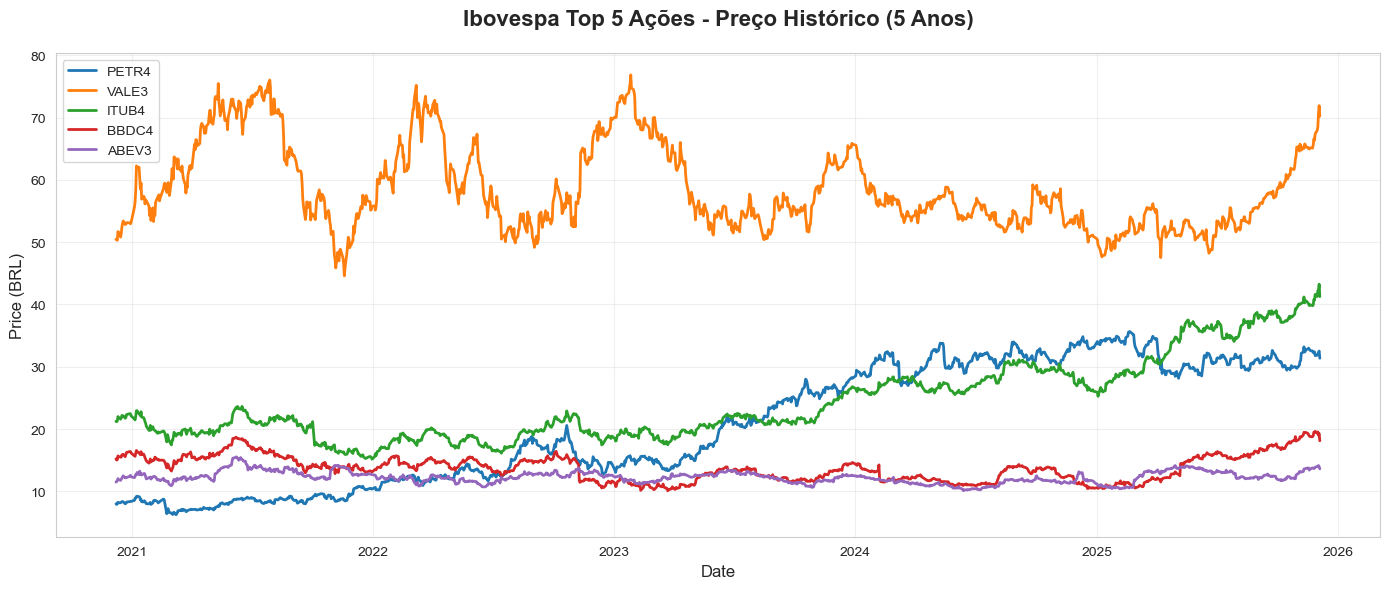

In [49]:
# Histórico de preços dos terrenos
# Plot price history
plot_price_history(data, title="Ibovespa Top 5 Ações - Preço Histórico (5 Anos)")
plt.show()

## 4. Distribuição de Retornos | Returns Distribution

Estatísticas de Retornos Diários:



,PETR4,VALE3,ITUB4,BBDC4,ABEV3
count,1246.0000,1246.0000,1246.0000,1246.0000,1246.0000
mean,0.0013,0.0004,0.0007,0.0003,0.0002
std,0.0215,0.0188,0.0161,0.0190,0.0150
min,-0.2071,-0.0759,-0.1796,-0.1738,-0.0647
25%,-0.0087,-0.0105,-0.0083,-0.0091,-0.0079
50%,0.0010,-0.0005,0.0003,0.0000,0.0000
75%,0.0128,0.0100,0.0099,0.0100,0.0078
max,0.1103,0.1040,0.0827,0.1564,0.0972


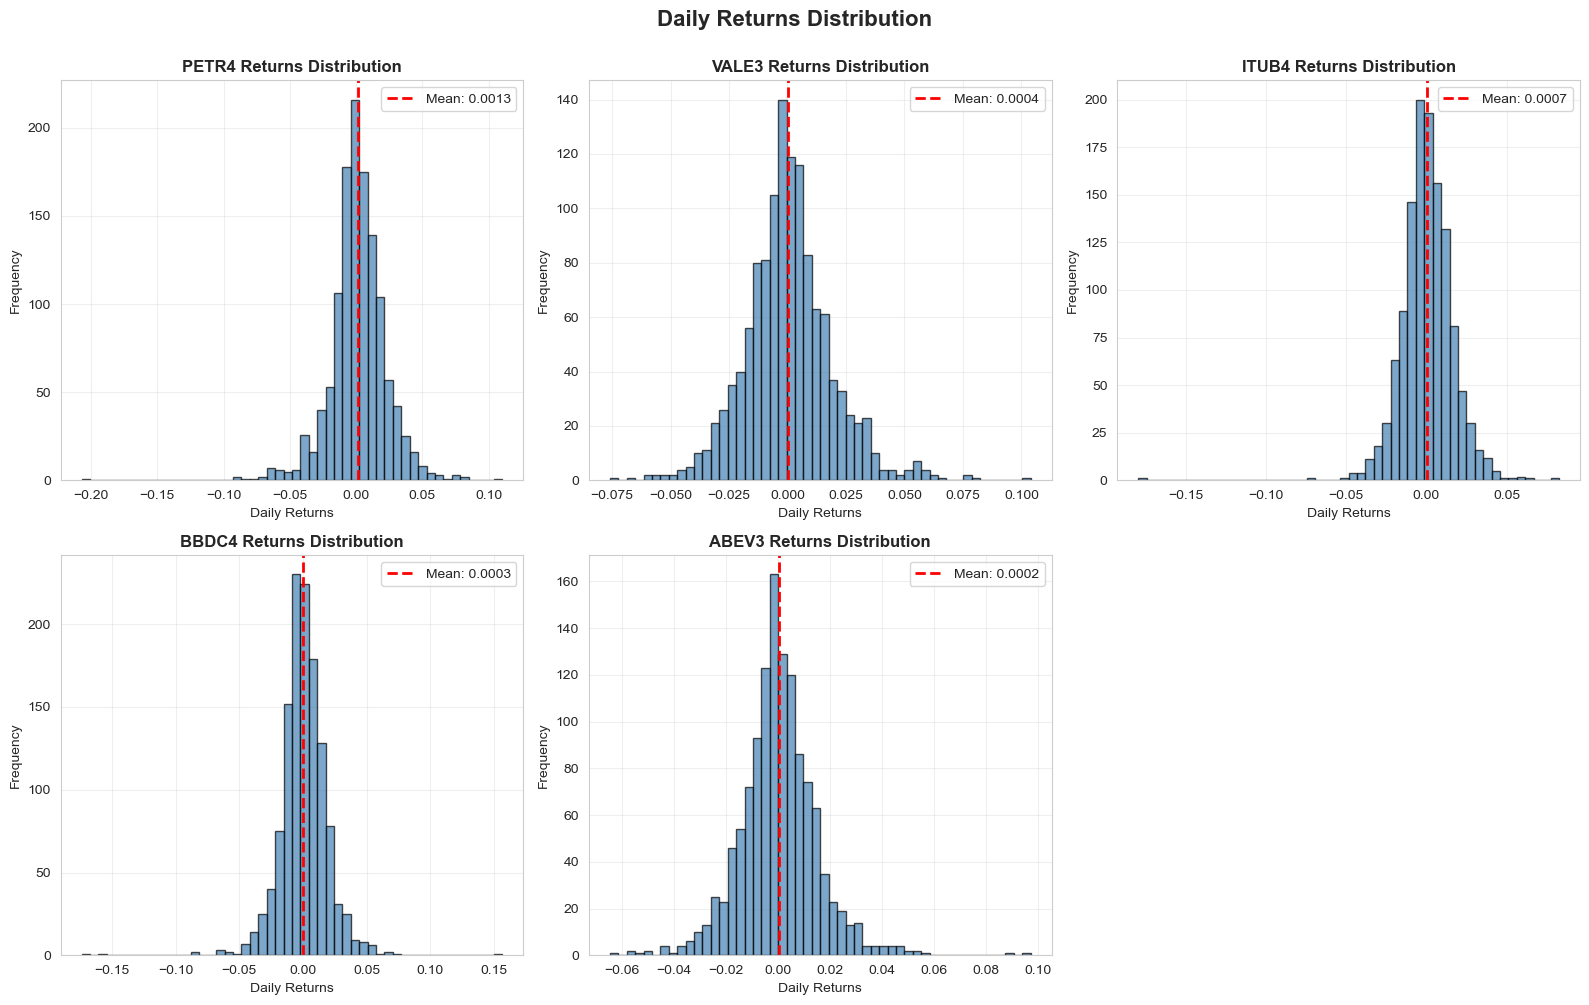

In [50]:
# Caulando retornos/Calculate returns
returns = data.pct_change().dropna()

# Exibindo estatisiticas/Display statistics
print("Estatísticas de Retornos Diários:\n")
display(returns.describe())

# grafico da distribuicao/Plot distribution
plot_returns_distribution(data)
plt.show()

## 5. Cálculo de Métricas de Risco | Risk Metrics Calculation

Vamos calcular 9 métricas de risco diferentes:
1. **Sharpe Ratio** - Retorno ajustado ao risco
2. **Sortino Ratio** - Similar ao Sharpe, mas considera apenas volatilidade negativa
3. **Volatility** - Desvio padrão dos retornos
4. **Maximum Drawdown** - Maior queda do pico ao vale
5. **VaR (95%)** - Value at Risk
6. **CVaR (95%)** - Conditional VaR (perda esperada além do VaR)
7. **Semi-Deviation** - Desvio padrão dos retornos negativos
8. **Ulcer Index** - Medida de risco baseada em drawdowns
9. **MAD** - Mean Absolute Deviation

In [51]:
# Calcula todas as métricas (252 dias úteis = período de 1 ano)
# Calculate all metrics (252 trading days = 1 year window)
metrics = analyzer.calculate_all_metrics(window=252)


📈 Calculating risk metrics for: PETR4, VALE3, ITUB4, BBDC4, ABEV3
  ℹ️  Using custom implementations (pandas + numpy)
  ⚙️  Calculating Sharpe Ratio...
  ⚙️  Calculating Sortino Ratio...
  ⚙️  Calculating Volatility...
  ⚙️  Calculating Maximum Drawdown...
  ⚙️  Calculating Value at Risk (VaR)...
  ⚙️  Calculating Conditional VaR (CVaR)...
  ⚙️  Calculating Semi-Deviation...
  ⚙️  Calculating Ulcer Index...
  ⚙️  Calculating Mean Absolute Deviation...
✅ All metrics calculated successfully!



## 6. Resumo das Métricas | Metrics Summary

In [52]:
# Obtemos as métricas mais recentes
# Get latest metrics
summary = analyzer.get_latest_metrics()

print("Métricas de risco mais recentes:\n")
display(summary.round(4))

# Exportar para CSV
# Export to CSV
summary.to_csv('../results/risk_metrics_summary.csv')
print("\nMétricas exportadas para resultados/risk_metrics_summary.csv")

Métricas de risco mais recentes:



,PETR4,VALE3,ITUB4,BBDC4,ABEV3
sharpe,0.9837,0.3723,0.6549,0.2693,0.2620
sortino,1.2528,0.6090,0.9036,0.3549,0.4065
volatility,0.3410,0.2992,0.2557,0.3012,0.2378
max_drawdown,-0.3910,-0.4134,-0.3587,-0.4604,-0.3488
var,-0.0343,-0.0289,-0.0228,-0.0272,-0.0233
cvar,-0.0515,-0.0386,-0.0340,-0.0425,-0.0321
semidev,0.2678,0.1829,0.1853,0.2286,0.1533
ulcer,0.1339,0.2440,0.1450,0.2839,0.2101
mad,0.0150,0.0138,0.0117,0.0131,0.0108



Métricas exportadas para resultados/risk_metrics_summary.csv


## 7. Visualização de Métricas | Metrics Visualization

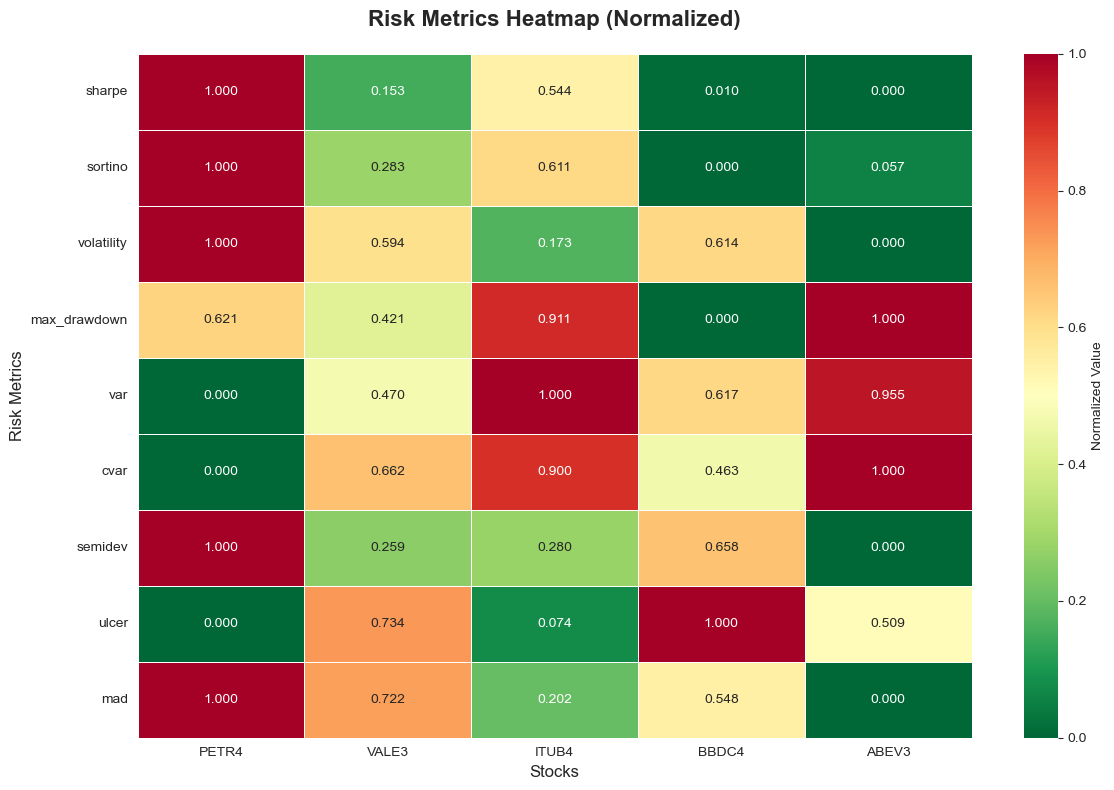

In [53]:
# Mapa de calor das métricas
# Heatmap of metrics
plot_metrics_heatmap(summary)
plt.show()

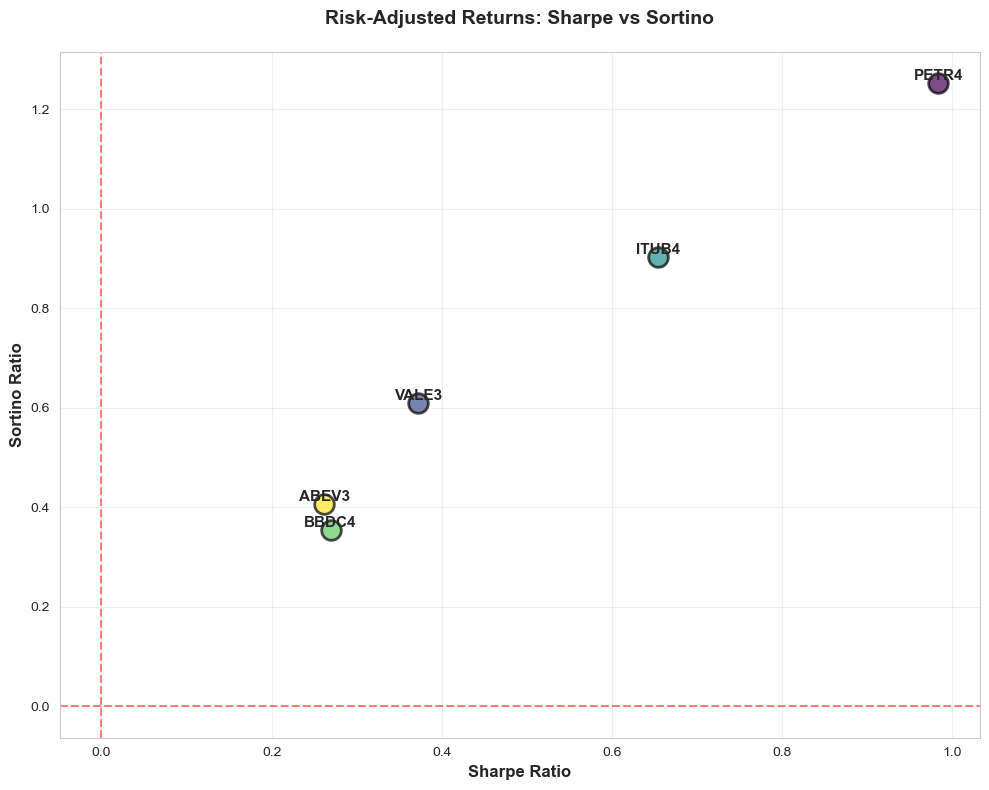

In [54]:
# Comparação entre Sharpe e Sortino
# Sharpe vs Sortino comparison
plot_sharpe_sortino_comparison(metrics)
plt.show()

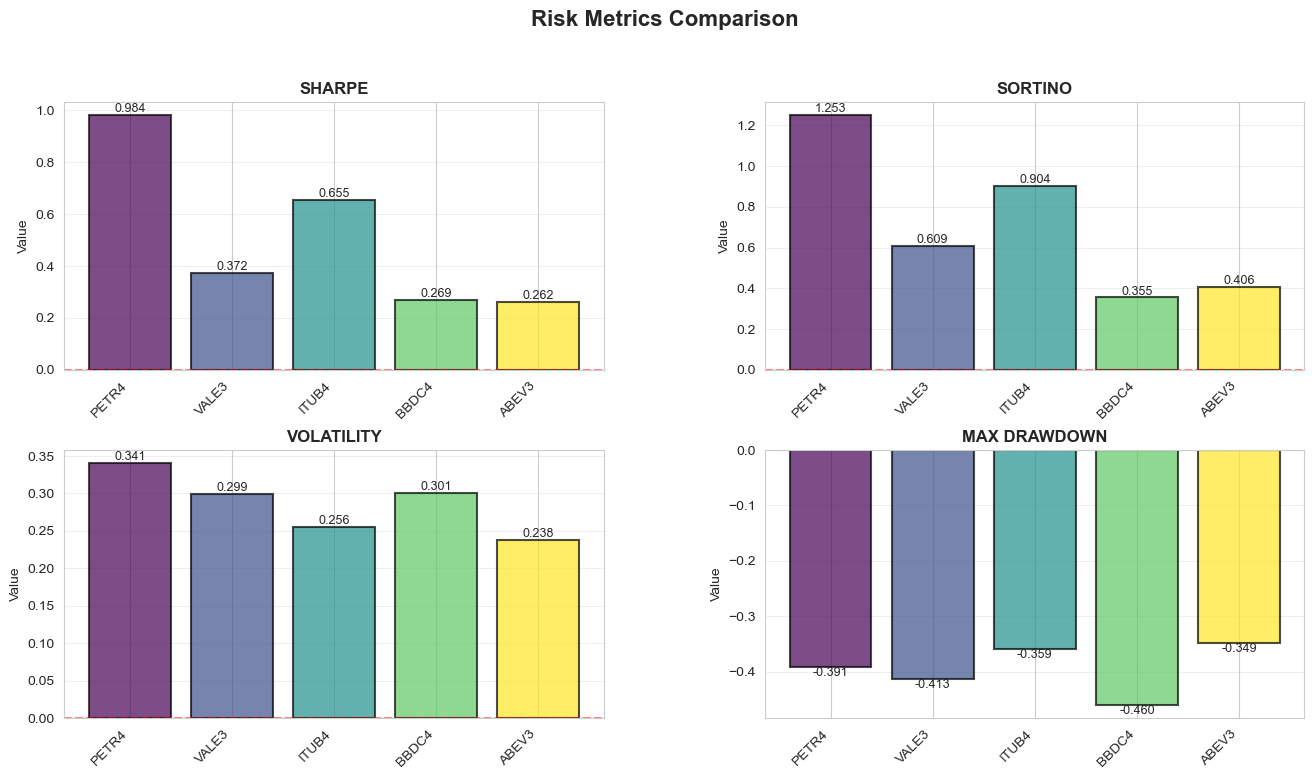

In [55]:
# Métricas de risco ao longo do tempo
# Risk metrics over time
plot_risk_metrics_comparison(metrics, metric_names=['sharpe', 'sortino', 'volatility', 'max_drawdown'])
plt.show()

## 8. Análise de Portfólio | Portfolio Analysis

Vamos comparar diferentes estratégias de alocação:
- **Equal Weight**: Peso igual para todas as ações
- **Conservative**: Maior peso em bancos e Ambev
- **Aggressive**: Maior peso em Petrobras e Vale
- **Defensive**: Maior peso em Ambev e bancos

In [56]:
# Criar estratégias de exemplo
# Create sample strategies
stock_names = list(data.columns)
strategies = create_sample_strategies(stock_names)

# Exibe estratégias
# Display strategies
print("Estratégias de Portfólio:\n")
for strategy_name, weights in strategies.items():
    print(f"\n{strategy_name}:")
    for stock, weight in weights.items():
        print(f"  {stock}: {weight*100:.1f}%")

Estratégias de Portfólio:


Equal Weight:
  PETR4: 20.0%
  VALE3: 20.0%
  ITUB4: 20.0%
  BBDC4: 20.0%
  ABEV3: 20.0%

Conservative:
  PETR4: 15.0%
  VALE3: 15.0%
  ITUB4: 30.0%
  BBDC4: 30.0%
  ABEV3: 10.0%

Aggressive:
  PETR4: 35.0%
  VALE3: 35.0%
  ITUB4: 10.0%
  BBDC4: 10.0%
  ABEV3: 10.0%

Defensive:
  PETR4: 10.0%
  VALE3: 10.0%
  ITUB4: 25.0%
  BBDC4: 25.0%
  ABEV3: 30.0%


In [57]:
# Compara estratégias
# Compare strategies
portfolio_analyzer = PortfolioAnalyzer(data)
comparison = portfolio_analyzer.compare_strategies(strategies)

print("\nComparação do desempenho do portfólio:\n")
display(comparison.round(4))

# Exporta resultados
# Export results
comparison.to_csv('../results/portfolio_comparison.csv')
print("\nComparação de portfólio exportada para resultados/portfolio_comparison.csv")


Comparação do desempenho do portfólio:



,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Skewness,Kurtosis,VaR (95%),CVaR (95%)
Equal Weight,0.9309,0.1515,0.1918,0.7899,-0.2128,-0.2504,2.7953,-0.0190,-0.0272
Conservative,0.8684,0.1478,0.2066,0.7155,-0.2443,-0.2810,3.3035,-0.0209,-0.0295
Aggressive,1.2649,0.1875,0.2099,0.8930,-0.2119,-0.2757,3.4928,-0.0212,-0.0297
Defensive,0.6928,0.1255,0.1950,0.6436,-0.2257,-0.2516,2.3976,-0.0197,-0.0278



Comparação de portfólio exportada para resultados/portfolio_comparison.csv


## 9. Dashboard Completo | Complete Dashboard

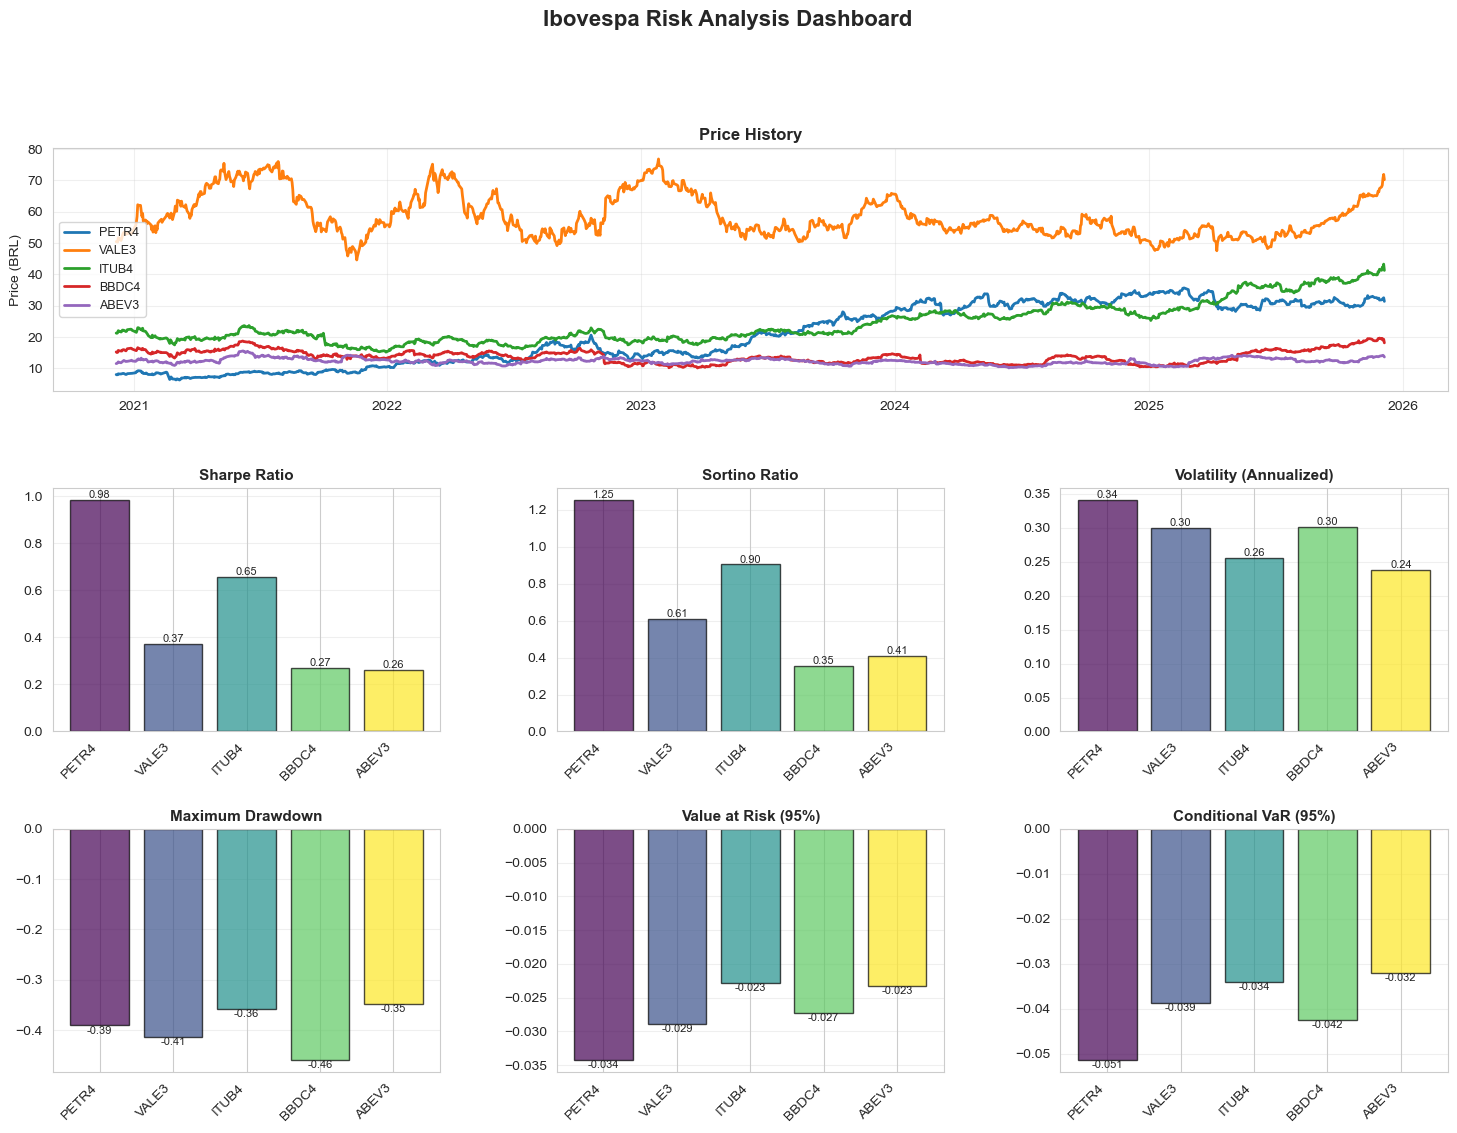

In [58]:
# Cria uma exibição abrangente
# Create comprehensive dashboard
create_dashboard(data, metrics)
plt.show()

## 10. Insights e Conclusões | Insights and Conclusions

### Análise dos Resultados | Results Analysis

Com base nas métricas calculadas, podemos observar:

1. **Sharpe Ratio**: Identifica ações com melhor retorno ajustado ao risco
2. **Volatilidade**: Mostra quais ações são mais voláteis
3. **Maximum Drawdown**: Indica o risco de perda máxima
4. **VaR/CVaR**: Quantifica o risco de cauda (tail risk)

### Próximos Passos | Next Steps

- Testar diferentes janelas de tempo
- Adicionar mais ações à análise
- Implementar otimização de portfólio
- Backtesting de estratégias

## 11. Outras Visualizações | Others Visualizations

Vamos criar visualizações mais sofisticadas para uma análise mais aprofundada:

*Let's create more sophisticated visualizations for in-depth analysis:*

1. **Drawdown Waterfall** - Magnitude das quedas
2. **VaR/CVaR Distribution** - Distribuição de tail risk
3. **Correlation Heatmap** - Relações entre ações
4. **Risk-Return Bubble** - Perfil risco-retorno

In [59]:
# Importar novas funções de visualização
# Import new visualization functions
from visualization.plots import (
    plot_drawdown_waterfall,
    plot_var_cvar_violin,
    plot_correlation_heatmap,
    plot_risk_return_bubble
)

print("Outras funções de visualização importadas!")

Outras funções de visualização importadas!


### 11.1 Drawdown Waterfall Chart

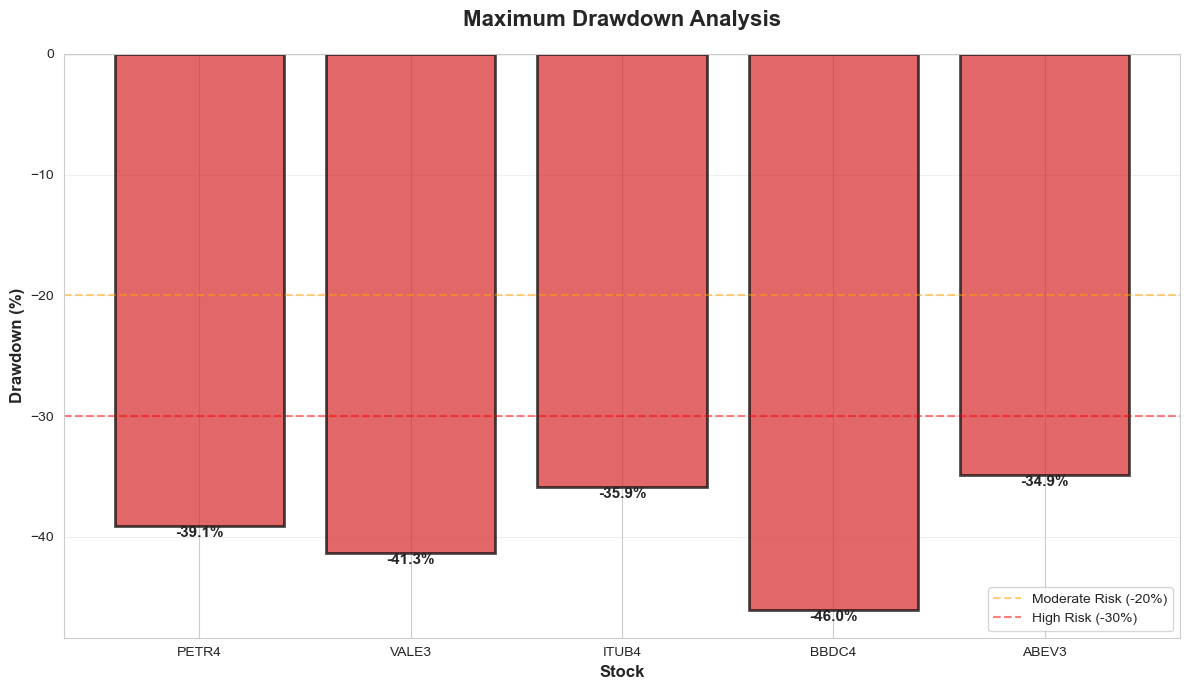


Interpretacao:
- As barras vermelhas mostram as perdas máximas em relação ao pico
- As linhas de referência indicam os níveis de risco
- O BBDC4 tem o maior drawdown (-46%)


In [60]:
# Gráfico de cascata mostrando o drawdown máximo
# Waterfall chart showing maximum drawdown
plot_drawdown_waterfall(data, metrics)
plt.show()

print("\nInterpretacao:")
print("- As barras vermelhas mostram as perdas máximas em relação ao pico")
print("- As linhas de referência indicam os níveis de risco")
print("- O BBDC4 tem o maior drawdown (-46%)")

### 11.2 VaR & CVaR Distribution

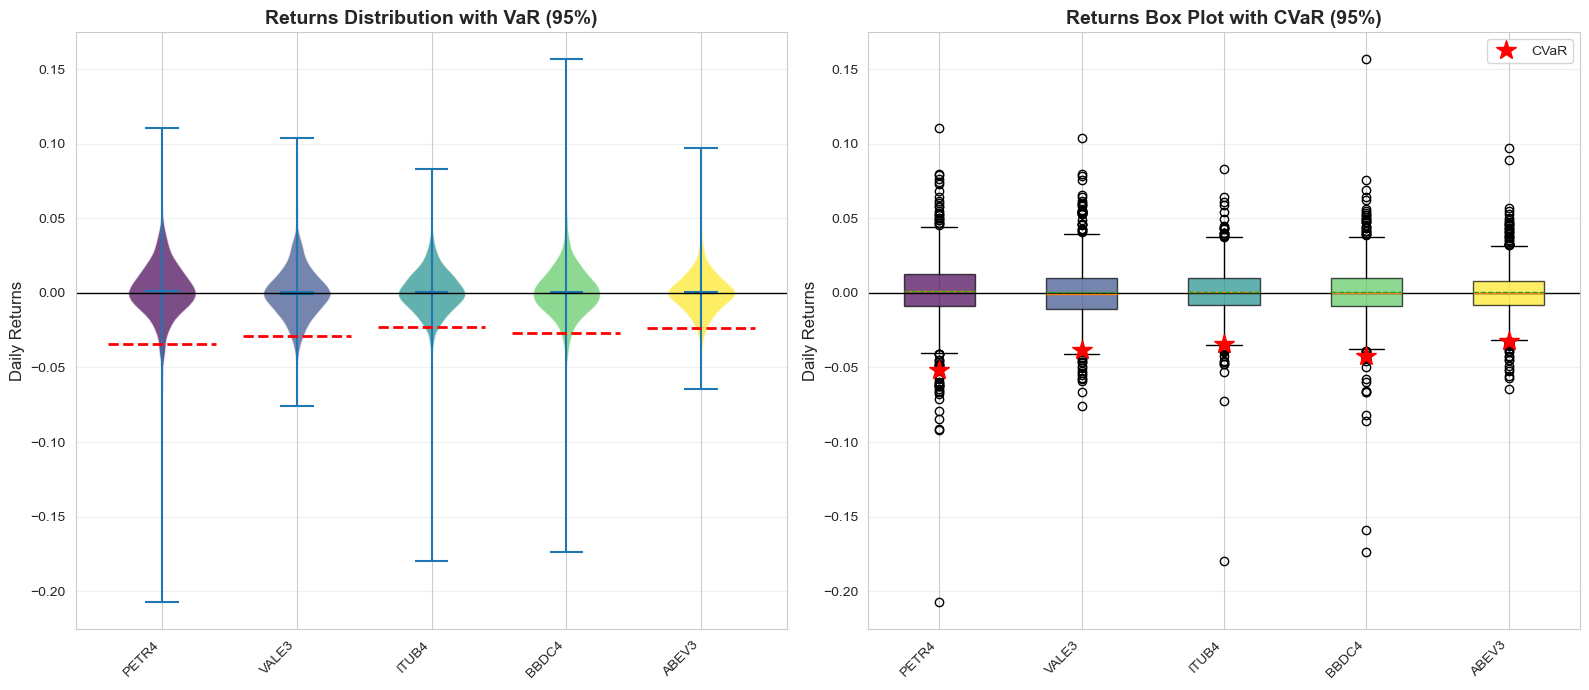


Interpretacao:
- Esquerda: Gráficos de violino mostram a distribuição completa dos retornos
- Direita: Gráficos de caixa destacam o CVaR (estrelas vermelhas)
- Violinos mais largos = maior volatilidade


In [61]:
# Gráficos de violino e de caixa mostrando a distribuição do risco de cauda
# Violin and box plots showing tail risk distribution
plot_var_cvar_violin(data)
plt.show()

print("\nInterpretacao:")
print("- Esquerda: Gráficos de violino mostram a distribuição completa dos retornos")
print("- Direita: Gráficos de caixa destacam o CVaR (estrelas vermelhas)")
print("- Violinos mais largos = maior volatilidade")

### 11.3 Correlation Heatmap

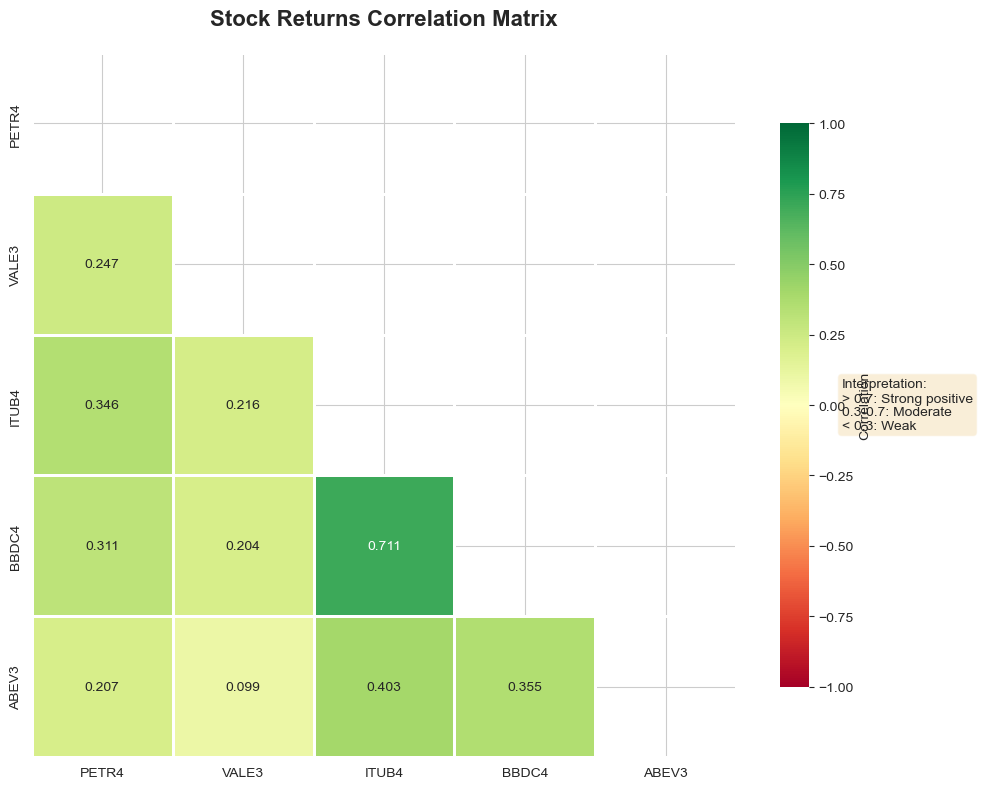


Principais conclusões:
- ITUB4 e BBDC4: Alta correlação (0,711) - ambos os bancos
- PETR4 e VALE3: Baixa correlação (0,247) - boa diversificação
- Menor correlação = melhor diversificação de portfólio


In [62]:
# Matriz de correlação entre ações
# Correlation matrix between stocks
plot_correlation_heatmap(data)
plt.show()

print("\nPrincipais conclusões:")
print("- ITUB4 e BBDC4: Alta correlação (0,711) - ambos os bancos")
print("- PETR4 e VALE3: Baixa correlação (0,247) - boa diversificação")
print("- Menor correlação = melhor diversificação de portfólio")

### 11.4 Risk-Return Bubble Chart

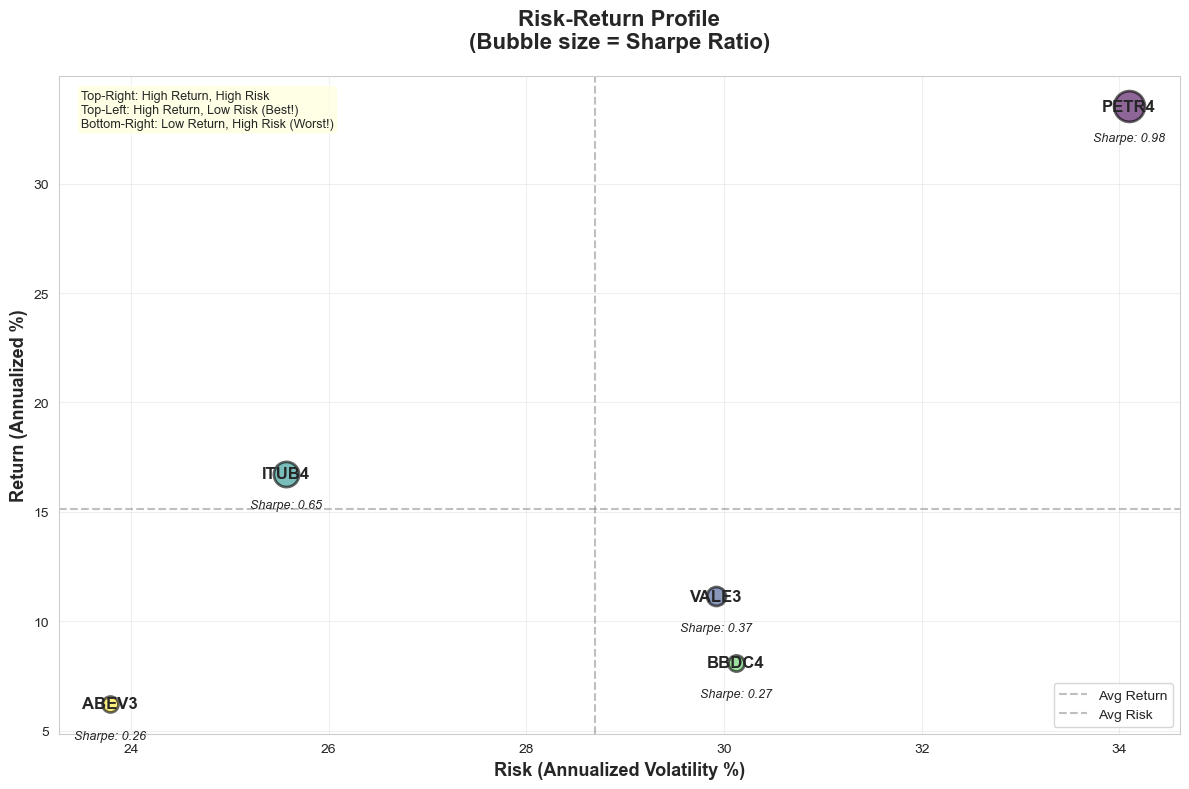


Interpretação:
- Eixo X: Risco (volatilidade)
- Eixo Y: Retorno (anualizado)
- Tamanho da bolha: Índice de Sharpe (maior = melhor)
- O quadrante superior esquerdo é o ideal: Alto retorno, baixo risco
- PETR4 apresenta o melhor desempenho ajustado ao risco


In [63]:
# Gráfico de bolhas: Risco vs. Retorno (tamanho da bolha = Índice de Sharpe)
# Bubble chart: Risk vs Return (bubble size = Sharpe Ratio)
plot_risk_return_bubble(data, metrics)
plt.show()

print("\nInterpretação:")
print("- Eixo X: Risco (volatilidade)")
print("- Eixo Y: Retorno (anualizado)")
print("- Tamanho da bolha: Índice de Sharpe (maior = melhor)")
print("- O quadrante superior esquerdo é o ideal: Alto retorno, baixo risco")
print("- PETR4 apresenta o melhor desempenho ajustado ao risco")

---

## Recursos Adicionais | Additional Resources

- [SquareQuant Documentation](https://github.com/SquareQuant/squarequant-package)
- [Project Repository](https://github.com/geansm2/ibovespa-risk-analysis)
- [Contributing Guide](../CONTRIBUTING.md)

**Autor | Author**: Gean Paulo Soares Machado 
**Data | Date**: December 2025